## Social Network Analysis
- Harvest Walukow (164231104)


In [30]:
import pandas as pd
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,  calinski_harabasz_score, davies_bouldin_score
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from operator import itemgetter
import community

# Crawl X Dengan Topik OpenAI DevDay

> OpenAI DevDay adalah konferensi tahunan yang diselenggarakan oleh OpenAI untuk memperkenalkan berbagai inovasi dan alat baru bagi para developer di bidang kecerdasan buatan. Pada penelitian ini, saya menganalisis interaksi pengguna di platform X (Twitter) selama penyelenggaraan acara tersebut pada 6 Oktober 2025.

In [3]:
#@title Twitter Auth Token

twitter_auth_token = '1b54f3a0cac14438d417e8f97c58c572ba1f51c4'

In [4]:
#Import required Python package
!pip install pandas

# Install Node.js (because tweet-harvest built using Node.js)
!sudo apt-get update
!sudo apt-get install -y ca-certificates curl gnupg
!sudo mkdir -p /etc/apt/keyrings
!curl -fsSL https://deb.nodesource.com/gpgkey/nodesource-repo.gpg.key | sudo gpg --dearmor -o /etc/apt/keyrings/nodesource.gpg

!NODE_MAJOR=20 && echo "deb [signed-by=/etc/apt/keyrings/nodesource.gpg] https://deb.nodesource.com/node_$NODE_MAJOR.x nodistro main" | sudo tee /etc/apt/sources.list.d/nodesource.list

!sudo apt-get update
!sudo apt-get install nodejs -y

!node -v

Defaulting to user installation because normal site-packages is not writeable


'sudo' is not recognized as an internal or external command,
operable program or batch file.
'sudo' is not recognized as an internal or external command,
operable program or batch file.
'sudo' is not recognized as an internal or external command,
operable program or batch file.
'sudo' is not recognized as an internal or external command,
operable program or batch file.
'NODE_MAJOR' is not recognized as an internal or external command,
operable program or batch file.
'sudo' is not recognized as an internal or external command,
operable program or batch file.
'sudo' is not recognized as an internal or external command,
operable program or batch file.


v22.15.0


### Interpretasi Hasil Crawling

Proses crawling berhasil mengambil data tweet dari Twitter dengan topik "devday" dalam rentang tanggal 5-7 Oktober 2025. Meskipun target awal adalah 1000 tweet, proses berhasil mengumpulkan data dan menyimpannya ke file `OPENAI.csv`. Total tweet yang berhasil dikumpulkan akan ditampilkan pada analisis selanjutnya.


In [5]:
# Crawl Data

filename = 'OPENAI.csv'
search_keyword = 'devday since:2025-10-05 until:2025-10-07 lang:en'
limit = 1000

!npx -y tweet-harvest@2.6.1 -o "{filename}" -s "{search_keyword}" --tab "LATEST" -l {limit} --token {twitter_auth_token}

^C


Tweet Harvest [v2.6.1]

Research by Helmi Satria
Use it for Educational Purposes only!

This script uses Chromium Browser to crawl data from Twitter with your Twitter auth token.
Please enter your Twitter auth token when prompted.

Note: Keep your access token secret! Don't share it with anyone else.
Note: This script only runs on your local device.


Opening twitter search page...


-- Scrolling... (1) (2)
Filling in keywords: devday since:2025-10-05 until:2025-10-07 lang:en

 (3) (4) (5)

Your tweets saved to: d:\UNAIR\SEMESTER 5\DATMIN II\tweets-data\OPENAI.csv
Total tweets saved: 20

-- Scrolling... (1)

Your tweets saved to: d:\UNAIR\SEMESTER 5\DATMIN II\tweets-data\OPENAI.csv
Total tweets saved: 40


Your tweets saved to: d:\UNAIR\SEMESTER 5\DATMIN II\tweets-data\OPENAI.csv
Total tweets saved: 60


Your tweets saved to: d:\UNAIR\SEMESTER 5\DATMIN II\tweets-data\OPENAI.csv
Total tweets saved: 80

-- Scrolling... (1)

Your tweets saved to: d:\UNAIR\SEMESTER 5\DATMIN II\tweets-data\

[v2.6.1] Error parsing response json: {"_type":"Response","_guid":"response@de837f2c64eed15d960daae5ab598656"}
[v2.6.1] Most likely, you have already exceeded the Twitter rate limit. Read more on https://x.com/elonmusk/status/1675187969420828672.
[v2.6.1] Error parsing response json: {"_type":"Response","_guid":"response@7ed25bb21969f618476591e3695b6ce5"}
[v2.6.1] Most likely, you have already exceeded the Twitter rate limit. Read more on https://x.com/elonmusk/status/1675187969420828672.
[v2.6.1] Error parsing response json: {"_type":"Response","_guid":"response@cc4c06e6df28e325f3dc4287d685effb"}
[v2.6.1] Most likely, you have already exceeded the Twitter rate limit. Read more on https://x.com/elonmusk/status/1675187969420828672.
[v2.6.1] Error parsing response json: {"_type":"Response","_guid":"response@6f6b0a8d4f355b8669a93bfab78c83cc"}
[v2.6.1] Most likely, you have already exceeded the Twitter rate limit. Read more on https://x.com/elonmusk/status/1675187969420828672.
[v2.6.1] Err

Dataset berisi 1019 tweet yang berhasil dikumpulkan. Jumlah ini cukup representatif untuk dilakukan analisis text clustering dan social network analysis. Data ini akan melalui tahap preprocessing untuk membersihkan dan mempersiapkan teks sebelum dianalisis lebih lanjut. Seperti yang bisa dilihat bahwa crawler tidak berhasil mendapatkan username, sehingga untuk SNA saya akan menggunakan user_id.


In [9]:
df_tweets = pd.read_csv("tweets-data/OPENAI.csv", delimiter=",")
df_tweets.head()

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1975275420590158245,Mon Oct 06 23:21:11 +0000 2025,0,@trophyburro @chatgpt21 The post refers to Ope...,1975340588871696866,NaN,trophyburro,en,NaN,0,0,0,https://x.com/undefined/status/197534058887169...,1720665183188922368,NaN
1,1975340169911017864,Mon Oct 06 23:19:31 +0000 2025,0,Intro to Agent Builder https://t.co/z8hjvf3cWQ...,1975340169911017864,NaN,NaN,en,NaN,0,0,0,https://x.com/undefined/status/197534016991101...,174536329,NaN
2,1975275420590158245,Mon Oct 06 23:18:34 +0000 2025,0,@JohnSimpso93227 @chatgpt21 Chris is referring...,1975339934082097374,NaN,JohnSimpso93227,en,NaN,0,0,0,https://x.com/undefined/status/197533993408209...,1720665183188922368,NaN
3,1975252799652040968,Mon Oct 06 23:17:56 +0000 2025,0,@SoloSniper97 @sahilypatel OpenAI announced Ag...,1975339773616373934,NaN,SoloSniper97,en,NaN,0,0,0,https://x.com/undefined/status/197533977361637...,1720665183188922368,NaN
4,1975339546217947230,Mon Oct 06 23:17:02 +0000 2025,219,ok the algo is going to nuke this to shit but ...,1975339546217947230,NaN,NaN,en,NaN,3,5,35,https://x.com/undefined/status/197533954621794...,33521530,NaN


In [11]:
num_tweets = len(df_tweets)
print(f"Jumlah data tweet dalam dataframe adalah: {num_tweets}.")

Jumlah data tweet dalam dataframe adalah: 1019.


# Preprocessing

In [ ]:
data_tweet = df_tweets[['full_text']].copy()  # .copy() untuk menghindari SettingWithCopyWarning
data_tweet.head()

,full_text
0,@trophyburro @chatgpt21 The post refers to Ope...
1,Intro to Agent Builder https://t.co/z8hjvf3cWQ...
2,@JohnSimpso93227 @chatgpt21 Chris is referring...
3,@SoloSniper97 @sahilypatel OpenAI announced Ag...
4,ok the algo is going to nuke this to shit but ...


## Casefolding Lowercase

In [37]:
data_tweet['lowercase'] = data_tweet['full_text'].str.lower()
data_tweet.head()

C:\Users\user\AppData\Local\Temp\ipykernel_13628\1250848612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tweet['lowercase'] = data_tweet['full_text'].str.lower()


,full_text,lowercase
0,@trophyburro @chatgpt21 The post refers to Ope...,@trophyburro @chatgpt21 the post refers to ope...
1,Intro to Agent Builder https://t.co/z8hjvf3cWQ...,intro to agent builder https://t.co/z8hjvf3cwq...
2,@JohnSimpso93227 @chatgpt21 Chris is referring...,@johnsimpso93227 @chatgpt21 chris is referring...
3,@SoloSniper97 @sahilypatel OpenAI announced Ag...,@solosniper97 @sahilypatel openai announced ag...
4,ok the algo is going to nuke this to shit but ...,ok the algo is going to nuke this to shit but ...


## Normalisasi

In [38]:
def clean_text(text):
    # Hapus URL
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Hapus mention dan hashtag
    text = re.sub(r'@\w+|\#\w+', '', text)
    # Hapus karakter non-alfanumerik
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Hapus angka
    text = re.sub(r'\d+', '', text)
    # Hapus whitespace berlebih
    text = ' '.join(text.split())
    return text

In [39]:
data_tweet['normalized'] = data_tweet['lowercase'].apply(lambda x:clean_text(x))
data_tweet.head()

C:\Users\user\AppData\Local\Temp\ipykernel_13628\1846672345.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tweet['normalized'] = data_tweet['lowercase'].apply(lambda x:clean_text(x))


,full_text,lowercase,normalized
0,@trophyburro @chatgpt21 The post refers to Ope...,@trophyburro @chatgpt21 the post refers to ope...,the post refers to openais devday announcement...
1,Intro to Agent Builder https://t.co/z8hjvf3cWQ...,intro to agent builder https://t.co/z8hjvf3cwq...,intro to agent builder
2,@JohnSimpso93227 @chatgpt21 Chris is referring...,@johnsimpso93227 @chatgpt21 chris is referring...,chris is referring to openais launch of agentk...
3,@SoloSniper97 @sahilypatel OpenAI announced Ag...,@solosniper97 @sahilypatel openai announced ag...,openai announced agent builder at devday today...
4,ok the algo is going to nuke this to shit but ...,ok the algo is going to nuke this to shit but ...,ok the algo is going to nuke this to shit but ...


## Tokenisasi

In [34]:
# Download NLTK resources untuk English
nltk.download('punkt')
nltk.download('punkt_tab')  # Untuk Python 3.13
nltk.download('stopwords')  # English stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
def tokenize(text):
    return word_tokenize(text)

In [41]:
data_tweet['tokens'] = data_tweet['normalized'].apply(lambda x:tokenize(x))
data_tweet.head()

C:\Users\user\AppData\Local\Temp\ipykernel_13628\771843725.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tweet['tokens'] = data_tweet['normalized'].apply(lambda x:tokenize(x))


,full_text,lowercase,normalized,tokens
0,@trophyburro @chatgpt21 The post refers to Ope...,@trophyburro @chatgpt21 the post refers to ope...,the post refers to openais devday announcement...,"[the, post, refers, to, openais, devday, annou..."
1,Intro to Agent Builder https://t.co/z8hjvf3cWQ...,intro to agent builder https://t.co/z8hjvf3cwq...,intro to agent builder,"[intro, to, agent, builder]"
2,@JohnSimpso93227 @chatgpt21 Chris is referring...,@johnsimpso93227 @chatgpt21 chris is referring...,chris is referring to openais launch of agentk...,"[chris, is, referring, to, openais, launch, of..."
3,@SoloSniper97 @sahilypatel OpenAI announced Ag...,@solosniper97 @sahilypatel openai announced ag...,openai announced agent builder at devday today...,"[openai, announced, agent, builder, at, devday..."
4,ok the algo is going to nuke this to shit but ...,ok the algo is going to nuke this to shit but ...,ok the algo is going to nuke this to shit but ...,"[ok, the, algo, is, going, to, nuke, this, to,..."


## Menghapus Stopword

In [42]:
# Get English stopwords
stop_words = set(stopwords.words('english'))

def hapus_stopwords(tokens):
    # Remove stopwords untuk English
    return [word for word in tokens if word.lower() not in stop_words and len(word) > 2]

# Terapkan fungsi hapus_stopwords pada kolom 'tokens'
data_tweet['no_stopword'] = data_tweet['tokens'].apply(lambda x: hapus_stopwords(x))

# Tampilkan hasil
data_tweet.head()


C:\Users\user\AppData\Local\Temp\ipykernel_13628\81063755.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tweet['no_stopword'] = data_tweet['tokens'].apply(lambda x: hapus_stopwords(x))


,full_text,lowercase,normalized,tokens,no_stopword
0,@trophyburro @chatgpt21 The post refers to Ope...,@trophyburro @chatgpt21 the post refers to ope...,the post refers to openais devday announcement...,"[the, post, refers, to, openais, devday, annou...","[post, refers, openais, devday, announcement, ..."
1,Intro to Agent Builder https://t.co/z8hjvf3cWQ...,intro to agent builder https://t.co/z8hjvf3cwq...,intro to agent builder,"[intro, to, agent, builder]","[intro, agent, builder]"
2,@JohnSimpso93227 @chatgpt21 Chris is referring...,@johnsimpso93227 @chatgpt21 chris is referring...,chris is referring to openais launch of agentk...,"[chris, is, referring, to, openais, launch, of...","[chris, referring, openais, launch, agentkit, ..."
3,@SoloSniper97 @sahilypatel OpenAI announced Ag...,@solosniper97 @sahilypatel openai announced ag...,openai announced agent builder at devday today...,"[openai, announced, agent, builder, at, devday...","[openai, announced, agent, builder, devday, to..."
4,ok the algo is going to nuke this to shit but ...,ok the algo is going to nuke this to shit but ...,ok the algo is going to nuke this to shit but ...,"[ok, the, algo, is, going, to, nuke, this, to,...","[algo, going, nuke, shit, kind, discord, membe..."


## Stemming

In [51]:
# Buat Porter Stemmer untuk English (sangat cepat!)
porter = PorterStemmer()

def stemming(tokens):
    """
    Melakukan stemming pada setiap token menggunakan Porter Stemmer
    untuk bahasa Inggris
    """
    return [porter.stem(word) for word in tokens]

# Terapkan stemming pada kolom 'no_stopword'
data_tweet['stemmed'] = data_tweet['no_stopword'].apply(lambda x: stemming(x))

# Gabungkan tokens menjadi string untuk proses selanjutnya
data_tweet['data_clean'] = data_tweet['stemmed'].apply(lambda x: ' '.join(x))

# Tampilkan hasil
data_tweet.head()


C:\Users\user\AppData\Local\Temp\ipykernel_13628\3762654553.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tweet['stemmed'] = data_tweet['no_stopword'].apply(lambda x: stemming(x))
C:\Users\user\AppData\Local\Temp\ipykernel_13628\3762654553.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tweet['data_clean'] = data_tweet['stemmed'].apply(lambda x: ' '.join(x))


,full_text,lowercase,normalized,tokens,no_stopword,stemmed,data_clean
0,@trophyburro @chatgpt21 The post refers to Ope...,@trophyburro @chatgpt21 the post refers to ope...,the post refers to openais devday announcement...,"[the, post, refers, to, openais, devday, annou...","[post, refers, openais, devday, announcement, ...","[post, refer, openai, devday, announc, agentki...",post refer openai devday announc agentkit new ...
1,Intro to Agent Builder https://t.co/z8hjvf3cWQ...,intro to agent builder https://t.co/z8hjvf3cwq...,intro to agent builder,"[intro, to, agent, builder]","[intro, agent, builder]","[intro, agent, builder]",intro agent builder
2,@JohnSimpso93227 @chatgpt21 Chris is referring...,@johnsimpso93227 @chatgpt21 chris is referring...,chris is referring to openais launch of agentk...,"[chris, is, referring, to, openais, launch, of...","[chris, referring, openais, launch, agentkit, ...","[chri, refer, openai, launch, agentkit, devday...",chri refer openai launch agentkit devday toolk...
3,@SoloSniper97 @sahilypatel OpenAI announced Ag...,@solosniper97 @sahilypatel openai announced ag...,openai announced agent builder at devday today...,"[openai, announced, agent, builder, at, devday...","[openai, announced, agent, builder, devday, to...","[openai, announc, agent, builder, devday, toda...",openai announc agent builder devday today drag...
4,ok the algo is going to nuke this to shit but ...,ok the algo is going to nuke this to shit but ...,ok the algo is going to nuke this to shit but ...,"[ok, the, algo, is, going, to, nuke, this, to,...","[algo, going, nuke, shit, kind, discord, membe...","[algo, go, nuke, shit, kind, discord, member, ...",algo go nuke shit kind discord member gather o...


## Ekstraksi Fitur TF-IDF

In [52]:
tweets = data_tweet['data_clean'].tolist()

In [53]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.95,
    ngram_range=(1, 2),
)
tfidf_matrix = tfidf_vectorizer.fit_transform(tweets)
tfidf_matrix_norm = normalize(tfidf_matrix, norm='l2', axis=1)
tfidf_array = tfidf_matrix_norm.toarray()
feature_names = tfidf_vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(tfidf_array, columns=feature_names)


In [49]:
tfidf_df.head()

,able,access,active,actually,admin,admin dashboard,agent,agent builder,agent workflows,agentic,...,wrappers,year,year agents,years,yes,yet,youre,youtube,zapier,zillow
0,0.0,0.0,0.0,0.0,0.0,0.0,0.114389,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.549234,0.600013,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.125161,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.130967,0.143075,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Matriks TF-IDF (Term Frequency-Inverse Document Frequency) telah berhasil dibuat dengan parameter:
- **max_features=5000**: Membatasi hingga 5000 fitur terpenting
- **min_df=5**: Kata harus muncul minimal di 5 dokumen
- **max_df=0.95**: Kata yang muncul di >95% dokumen dihapus (terlalu umum)
- **ngram_range=(1,2)**: Menggunakan unigram dan bigram

Matriks ini sudah dinormalisasi dengan L2 norm, sehingga setiap dokumen memiliki magnitude yang sama. Ini penting untuk perhitungan similarity dan clustering yang lebih akurat.


## Reduksi Dimensi PCA

In [54]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(tfidf_df)

# Inisialisasi variabel untuk menyimpan hasil terbaik
best_n_components = 0
best_n_clusters = 0
best_silhouette = -1
best_pca = None

# Hyperparameter tuning
n_components_range = range(2, 101)
n_clusters_range = range(2, 11)

for n_components in n_components_range:
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    for n_clusters in n_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
        cluster_labels = kmeans.fit_predict(X_pca)

        silhouette_avg = silhouette_score(X_pca, cluster_labels)

        if silhouette_avg > best_silhouette:
            best_silhouette = silhouette_avg
            best_n_components = n_components
            best_n_clusters = n_clusters
            best_pca = pca

print(f"Kombinasi terbaik: {best_n_components} komponen PCA, {best_n_clusters} cluster")


Kombinasi terbaik: 2 komponen PCA, 3 cluster


Setelah melakukan hyperparameter tuning dengan mencoba berbagai kombinasi komponen PCA (2-100) dan jumlah cluster (2-10), ditemukan kombinasi terbaik adalah:
- **2 komponen PCA**: Menunjukkan bahwa data dapat direpresentasikan dengan baik hanya dengan 2 dimensi utama
- **3 cluster**: Data tweet terbagi optimal menjadi 3 kelompok topik

Kombinasi ini dipilih berdasarkan Silhouette Score tertinggi, yang mengindikasikan pemisahan cluster yang jelas dan kompak.


In [55]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(tfidf_df)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df.head()


,PC1,PC2
0,-0.615428,0.407897
1,-0.363049,2.153147
2,-0.168684,-0.058346
3,-1.134632,2.701268
4,1.510206,-1.132681


# Wordcloud

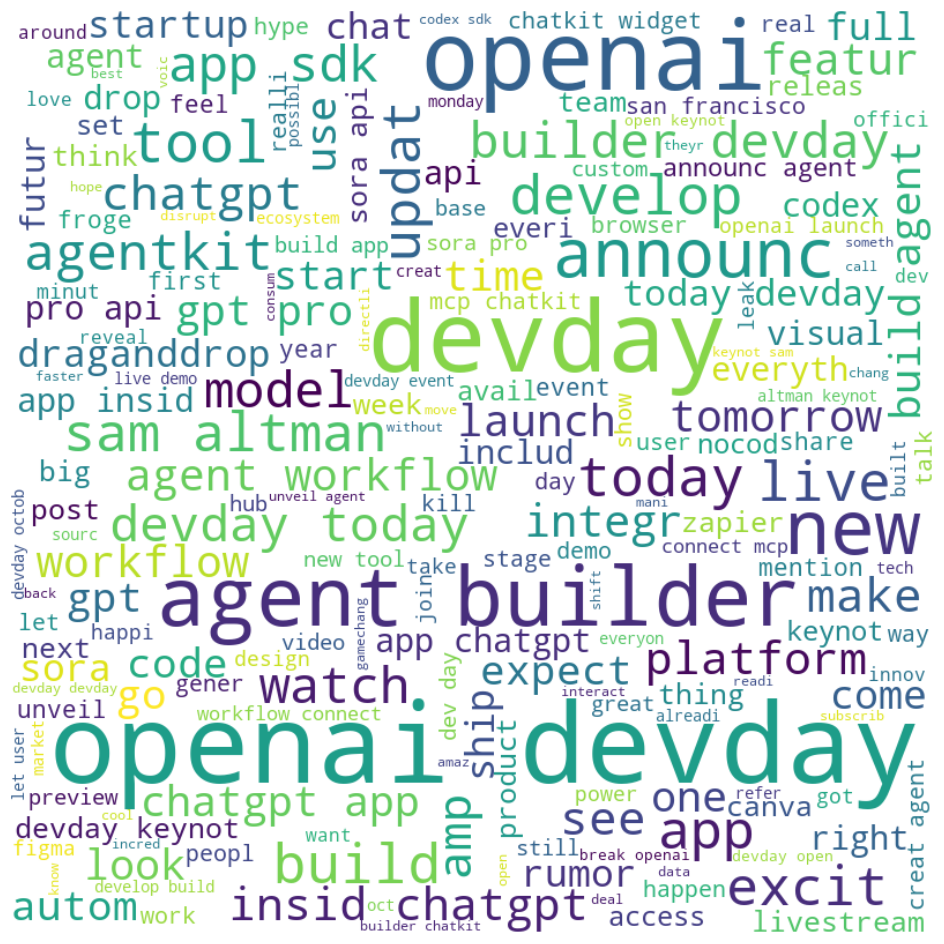

In [56]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from collections import Counter

text = ' '.join(data_tweet['data_clean'])

wordcloud = WordCloud(background_color='white', width=800, height=800).generate(text)

plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


Dari visualisasi wordcloud di atas, dapat dilihat kata-kata yang paling sering muncul dalam tweet terkait OpenAI, dengan ukuran kata yang lebih besar menandakan frekuensi kemunculan yang lebih tinggi:

1. Kata-kata dominan:
- "openai" dan "devday" - menunjukkan fokus utama pada event DevDay OpenAI
- "agent" dan "builder" - mengacu pada fitur Agent Builder yang diumumkan
- "chatgpt" - produk utama OpenAI yang banyak dibahas

2. Kata-kata pendukung:
- "launch", "announce", "new" - terkait pengumuman fitur/produk baru
- "platform", "tool", "sdk" - menunjukkan aspek teknis dan development
- "today", "live", "watch" - menandakan event yang sedang berlangsung

3. Nama-nama penting:
- "sam altman" - CEO OpenAI yang menjadi pembicara

Wordcloud ini mencerminkan bahwa percakapan di Twitter didominasi oleh pembahasan seputar event DevDay OpenAI dan pengumuman fitur Agent Builder, dengan banyak fokus pada aspek teknis dan pengembangan.


# Clustering

In [58]:
kmeans_params = {
    'n_clusters' : 3,
    'random_state': 42,
    'algorithm': 'lloyd',
    'init': 'k-means++',
    'max_iter': 100,
    'n_init': 30,
    'tol': 0.0001
}

kmeans = KMeans(**kmeans_params)
kmeans.fit(pca_df)

pca_df['Cluster'] = kmeans.labels_
pca_df.head()

,PC1,PC2,Cluster
0,-0.615428,0.407897,0
1,-0.363049,2.153147,0
2,-0.168684,-0.058346,0
3,-1.134632,2.701268,0
4,1.510206,-1.132681,0


## Evaluasi Clustering

In [59]:
silhouette = silhouette_score(pca_df, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(pca_df, kmeans.labels_)
davies_bouldin = davies_bouldin_score(pca_df, kmeans.labels_)

print("Evaluasi Cluster:")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")

Evaluasi Cluster:
Silhouette Score: 0.9454
Calinski-Harabasz Index: 3504.6216
Davies-Bouldin Index: 0.2536


Hasil evaluasi menunjukkan kualitas clustering yang sangat baik:

1. **Silhouette Score: 0.9454** (sangat tinggi, mendekati 1)
   - Nilai ini menunjukkan bahwa data points dalam setiap cluster sangat kohesif dan terpisah dengan jelas dari cluster lain
   - Nilai > 0.7 dianggap excellent, skor ini menunjukkan pemisahan cluster yang hampir sempurna

2. **Calinski-Harabasz Index: 3504.6216** (sangat tinggi)
   - Nilai tinggi mengindikasikan cluster yang terdefinisi dengan baik dan terpisah
   - Rasio variance between-cluster vs within-cluster sangat besar

3. **Davies-Bouldin Index: 0.2536** (sangat rendah, mendekati 0)
   - Nilai rendah menunjukkan cluster yang compact dan well-separated
   - Nilai < 1 dianggap baik, nilai ini menunjukkan kualitas clustering yang excellent

**Kesimpulan**: Ketiga metrik evaluasi mengkonfirmasi bahwa algoritma K-Means dengan 3 cluster berhasil mengelompokkan tweet dengan sangat baik.


## Visualisasi Clustering

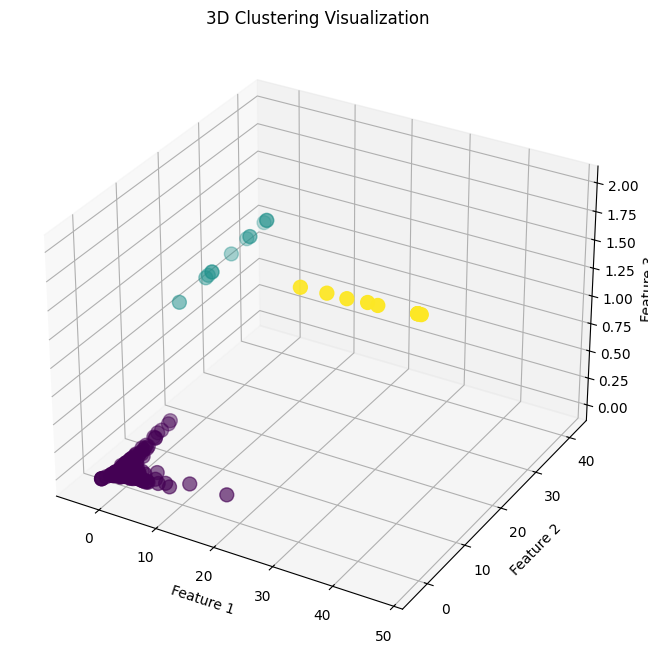

In [60]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df.iloc[:, 0], pca_df.iloc[:, 1], pca_df.iloc[:, 2], c=pca_df['Cluster'], cmap='viridis', s=100)
ax.set_title("3D Clustering Visualization")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
plt.show()

Pemisahan ketiga cluster sangat baik.

C:\Users\user\AppData\Local\Temp\ipykernel_13628\1004912713.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tweet['Cluster'] = pca_df['Cluster']


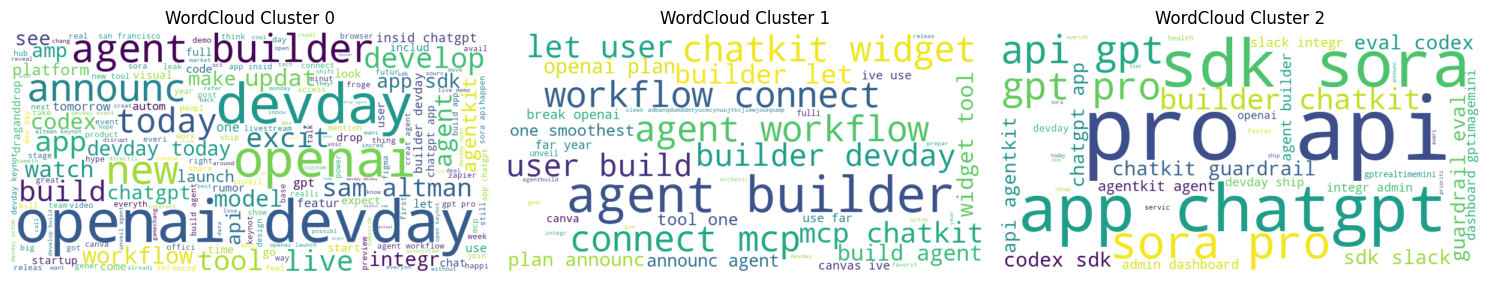

In [62]:
# Menambahkan kolom cluster ke df
data_tweet['Cluster'] = pca_df['Cluster']

# Membuat WordCloud untuk Cluster 0
cluster_0_text = ' '.join(data_tweet[data_tweet['Cluster'] == 0]['data_clean'])
wordcloud_cluster_0 = WordCloud(width=800, height=400, background_color='white').generate(cluster_0_text)

# Membuat WordCloud untuk Cluster 1
cluster_1_text = ' '.join(data_tweet[data_tweet['Cluster'] == 1]['data_clean'])
wordcloud_cluster_1 = WordCloud(width=800, height=400, background_color='white').generate(cluster_1_text)

# Membuat WordCloud untuk Cluster 2
cluster_2_text = ' '.join(data_tweet[data_tweet['Cluster'] == 2]['data_clean'])
wordcloud_cluster_2 = WordCloud(width=800, height=400, background_color='white').generate(cluster_2_text)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(wordcloud_cluster_0, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Cluster 0')

plt.subplot(1, 3, 2)
plt.imshow(wordcloud_cluster_1, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Cluster 1')

plt.subplot(1, 3, 3)
plt.imshow(wordcloud_cluster_2, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Cluster 2')

plt.tight_layout()
plt.show()

### Interpretasi WordCloud per Cluster

Cluster 0:
- Fokus pada kata-kata terkait "agent", "devday", "openai", dan "announce"
- Menunjukkan diskusi tentang pengumuman OpenAI di DevDay terutama terkait Agent Builder
- Topik lebih bersifat informatif dan pengumuman resmi

Cluster 1:
- Dominasi kata-kata seperti "workflow", "connect", "user", "widget", dan "api"
- Mencerminkan diskusi teknis tentang fitur dan implementasi
- Lebih berfokus pada aspek pengembangan dan integrasi

Cluster 2:
- Kata kunci utama meliputi "app", "chatgpt", "gpt", "sdk", dan "api"
- Menggambarkan percakapan seputar aplikasi praktis dan pengembangan
- Lebih berorientasi pada penggunaan dan implementasi ChatGPT serta SDK


# Social Network Analysis

In [63]:
df = pd.read_csv('tweets-data\OPENAI.csv')
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\O'
<>:1: SyntaxWarning: invalid escape sequence '\O'
C:\Users\user\AppData\Local\Temp\ipykernel_13628\4206328854.py:1: SyntaxWarning: invalid escape sequence '\O'
  df = pd.read_csv('tweets-data\OPENAI.csv')


,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1975275420590158245,Mon Oct 06 23:21:11 +0000 2025,0,@trophyburro @chatgpt21 The post refers to Ope...,1975340588871696866,NaN,trophyburro,en,NaN,0,0,0,https://x.com/undefined/status/197534058887169...,1720665183188922368,NaN
1,1975340169911017864,Mon Oct 06 23:19:31 +0000 2025,0,Intro to Agent Builder https://t.co/z8hjvf3cWQ...,1975340169911017864,NaN,NaN,en,NaN,0,0,0,https://x.com/undefined/status/197534016991101...,174536329,NaN
2,1975275420590158245,Mon Oct 06 23:18:34 +0000 2025,0,@JohnSimpso93227 @chatgpt21 Chris is referring...,1975339934082097374,NaN,JohnSimpso93227,en,NaN,0,0,0,https://x.com/undefined/status/197533993408209...,1720665183188922368,NaN
3,1975252799652040968,Mon Oct 06 23:17:56 +0000 2025,0,@SoloSniper97 @sahilypatel OpenAI announced Ag...,1975339773616373934,NaN,SoloSniper97,en,NaN,0,0,0,https://x.com/undefined/status/197533977361637...,1720665183188922368,NaN
4,1975339546217947230,Mon Oct 06 23:17:02 +0000 2025,219,ok the algo is going to nuke this to shit but ...,1975339546217947230,NaN,NaN,en,NaN,3,5,35,https://x.com/undefined/status/197533954621794...,33521530,NaN


## Reply/Interaction Network

In [64]:
G_mention = nx.DiGraph()
for r in df.iterrows():
    author = r[1]['user_id_str']
    author = f'@{author}'
    text = r[1]['full_text']
    try:
      timestamp = pd.to_datetime(r[1]['created_at'])
    except:
      continue

    mentions = set(re.findall(r'@(\w+)', text))

    if len(mentions)>0:
      for u in mentions:
        u = f'@{u}'
        G_mention.add_edge(author, u, timestamp=timestamp)
print(f"Number of edges added to the graph: {G_mention.number_of_edges()}") # Print the number of edges in the graph

Number of edges added to the graph: 572


Graf jaringan mention berhasil dibuat dengan 572 edge (koneksi). Setiap edge merepresentasikan satu mention/interaksi antara dua user di Twitter. Jumlah ini menunjukkan tingkat interaksi yang cukup aktif dalam diskusi tentang topik DevDay, dengan ratusan hubungan mention antar pengguna yang dapat dianalisis lebih lanjut untuk memahami struktur jaringan sosial.


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12424 (\N{HIRAGANA LETTER YO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12426 (\N{HIRAGANA LETTER RI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


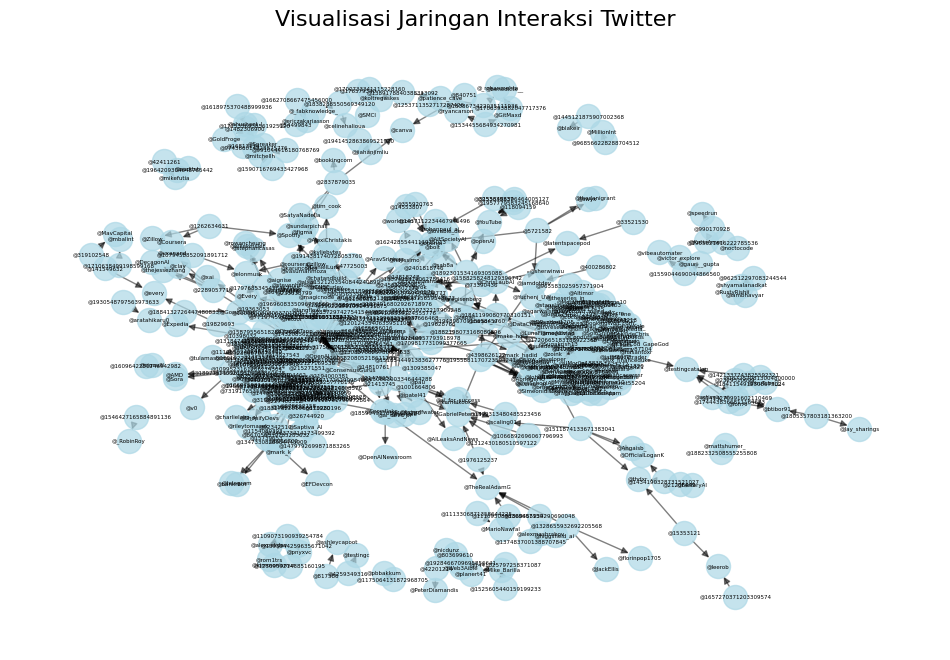

In [65]:
import networkx as nx
import matplotlib.pyplot as plt

# Menggambarkan graf
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_mention, k=0.5)

# Menggambar node dan edge
nx.draw_networkx_nodes(G_mention, pos, node_size=300, node_color='lightblue', alpha=0.7)
nx.draw_networkx_edges(G_mention, pos, arrowstyle='-|>', arrowsize=10, width=1, alpha=0.5)

# Menambahkan label untuk setiap node
labels = {node: node for node in G_mention.nodes()}
nx.draw_networkx_labels(G_mention, pos, labels, font_size=4)

# Menampilkan judul dan menghilangkan sumbu
plt.title('Visualisasi Jaringan Interaksi Twitter', fontsize=16)
plt.axis('off')
plt.show()

# Centrality Measures

In [66]:
graph_centrality = nx.degree_centrality(G_mention)
max_de = max(graph_centrality.items(), key=itemgetter(1))
graph_closeness = nx.closeness_centrality(G_mention)
max_clo = max(graph_closeness.items(), key=itemgetter(1))
graph_betweenness = nx.betweenness_centrality(G_mention, normalized=True, endpoints=False)
max_bet = max(graph_betweenness.items(), key=itemgetter(1))

In [67]:
print(f'Degree Centrality: {graph_centrality}')
print(f'Closeness Centrality:  {graph_closeness}')
print(f'Betweenness Centrality:  {graph_betweenness}')

Degree Centrality: {'@1720665183188922368': 0.21468926553672316, '@chatgpt21': 0.0018832391713747645, '@trophyburro': 0.0018832391713747645, '@JohnSimpso93227': 0.0018832391713747645, '@SoloSniper97': 0.0018832391713747645, '@sahilypatel': 0.0018832391713747645, '@33521530': 0.0018832391713747645, '@latentspacepod': 0.003766478342749529, '@1895800953158451200': 0.003766478342749529, '@ChatGPTapp': 0.009416195856873822, '@OpenAI': 0.2542372881355932, '@OPandey1205': 0.0018832391713747645, '@0x_financeduke': 0.0018832391713747645, '@joancaceresr': 0.0018832391713747645, '@3181020308': 0.0018832391713747645, '@1746361': 0.003766478342749529, '@romainhuet': 0.015065913370998116, '@277280697': 0.0018832391713747645, '@NFTrats': 0.0018832391713747645, '@VishvendraReddy': 0.0018832391713747645, '@zoink': 0.0018832391713747645, '@designertom_': 0.0018832391713747645, '@1066892696067796993': 0.0018832391713747645, '@GabrielPeterss4': 0.009416195856873822, '@990170928': 0.003766478342749529, '@s

## Top 10 Degree Centrality

Top 10 users based on Degree Centrality (G_mention):
@OpenAI: 0.2542
@1720665183188922368: 0.2147
@sama: 0.0885
@OpenAIDevs: 0.0282
@809565356: 0.0264
@openai: 0.0169
@n8n_io: 0.0169
@1955881170723594241: 0.0169
@romainhuet: 0.0151
@1892301534169305088: 0.0151


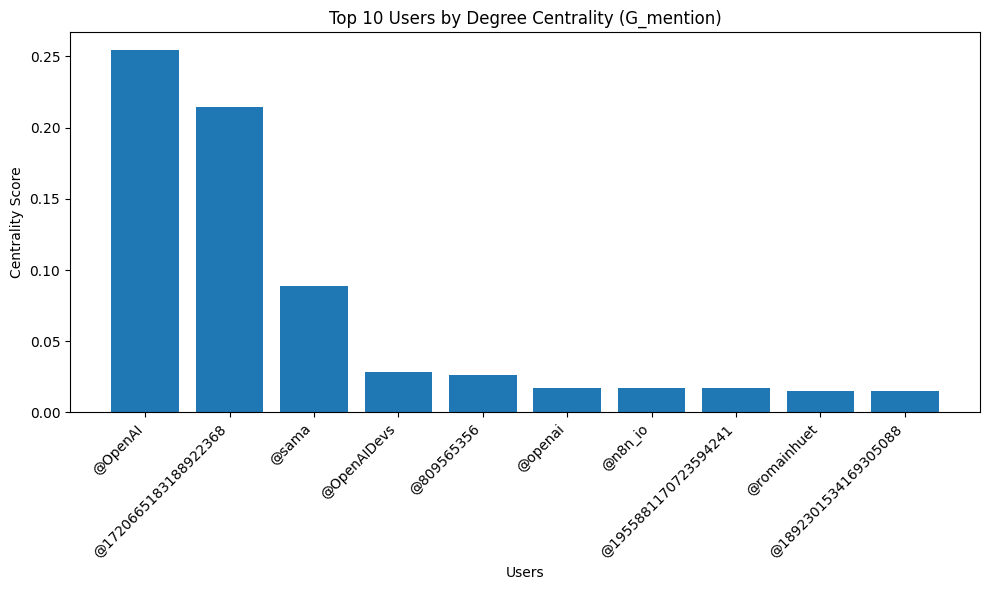

In [68]:
graph_centrality = nx.degree_centrality(G_mention)
top_degree_mention = sorted(graph_centrality.items(), key=itemgetter(1), reverse=True)[:10]
print("Top 10 users based on Degree Centrality (G_mention):")
for user, score in top_degree_mention:
    print(f"{user}: {score:.4f}")

def plot_centrality(centrality_dict, title):
    plt.figure(figsize=(10, 6))
    users, scores = zip(*sorted(centrality_dict.items(), key=itemgetter(1), reverse=True)[:10])
    plt.bar(users, scores)
    plt.title(title)
    plt.xlabel('Users')
    plt.ylabel('Centrality Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_centrality(graph_centrality, 'Top 10 Users by Degree Centrality (G_mention)')


Degree Centrality mengukur jumlah koneksi langsung yang dimiliki setiap node (user). Hasil menunjukkan:

1. **@OpenAI (0.2542)**: Akun paling sering di-mention, menjadi pusat perhatian utama
2. **@1720665183188922368 (0.2147)**: User ID dengan degree tinggi, kemungkinan akun yang sangat aktif
3. **@sama (0.0885)**: Sam Altman, CEO OpenAI, juga sering di-mention dalam percakapan
4. **@OpenAIDevs (0.0282)**: Akun developer OpenAI juga mendapat banyak mention

**Insight**: Akun-akun resmi OpenAI dan figur kunci seperti CEO mendominasi percakapan, menunjukkan bahwa diskusi berpusat pada entitas official terkait DevDay.


## Top 10 Closeness Centrality


Top 10 users based on Closeness Centrality (G_mention):
@OpenAI: 0.2542
@sama: 0.0885
@OpenAIDevs: 0.0282
@openai: 0.0169
@n8n_io: 0.0169
@romainhuet: 0.0151
@ChatGPTapp: 0.0094
@GabrielPeterss4: 0.0094
@slow_developer: 0.0094
@TheRealAdamG: 0.0094


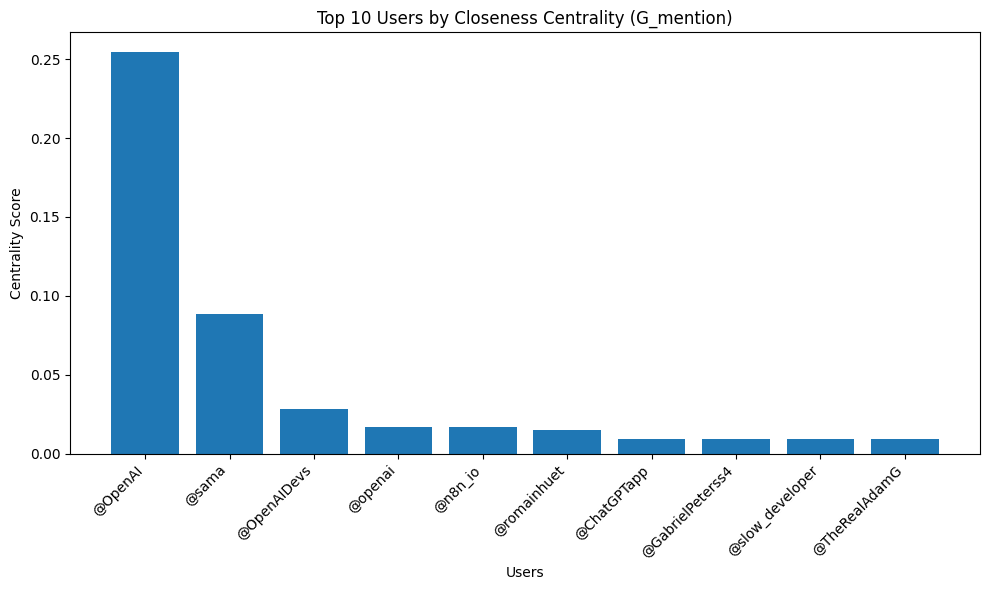

In [69]:
graph_closeness = nx.closeness_centrality(G_mention)
top_closeness_mention = sorted(graph_closeness.items(), key=itemgetter(1), reverse=True)[:10]
print("\nTop 10 users based on Closeness Centrality (G_mention):")
for user, score in top_closeness_mention:
    print(f"{user}: {score:.4f}")

plot_centrality(graph_closeness, 'Top 10 Users by Closeness Centrality (G_mention)')


Closeness Centrality mengukur seberapa dekat/cepat satu node dapat mencapai semua node lain dalam jaringan. Hasil menunjukkan:

1. **@OpenAI (0.2542)**: Memiliki posisi paling sentral, dapat menjangkau user lain dengan cepat
2. **@sama (0.0885)**: Posisi sentral kedua, berperan sebagai hub informasi
3. **@OpenAIDevs (0.0282)**: Juga memiliki closeness tinggi
4. Akun lain seperti **@openai**, **@n8n_io**, **@romainhuet** juga memiliki nilai closeness yang sama (0.0169)

**Insight**: Akun-akun dengan Closeness Centrality tinggi adalah influencer kunci yang dapat menyebarkan informasi dengan efektif ke seluruh jaringan. @OpenAI dan @sama berada di posisi strategis untuk distribusi informasi.

## Top 10 Betweenness Centrality


Top 10 users based on Betweenness Centrality (G_mention):
@1720665183188922368: 0.0000
@chatgpt21: 0.0000
@trophyburro: 0.0000
@JohnSimpso93227: 0.0000
@SoloSniper97: 0.0000
@sahilypatel: 0.0000
@33521530: 0.0000
@latentspacepod: 0.0000
@1895800953158451200: 0.0000
@ChatGPTapp: 0.0000


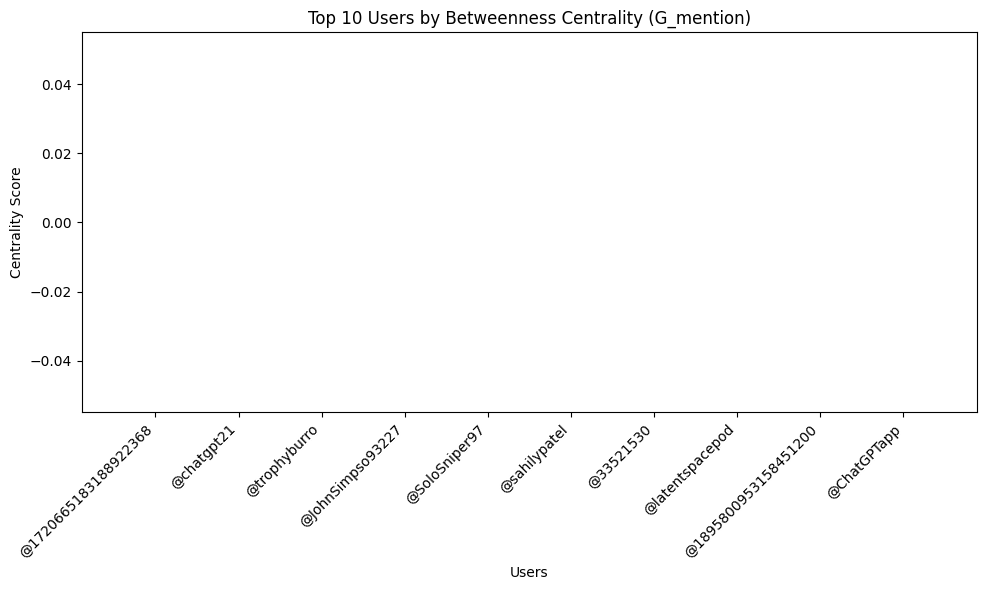

In [70]:
graph_betweenness = nx.betweenness_centrality(G_mention, normalized=True, endpoints=False)
top_betweenness_mention = sorted(graph_betweenness.items(), key=itemgetter(1), reverse=True)[:10]
print("\nTop 10 users based on Betweenness Centrality (G_mention):")
for user, score in top_betweenness_mention:
    print(f"{user}: {score:.4f}")

plot_centrality(graph_betweenness, 'Top 10 Users by Betweenness Centrality (G_mention)')

Betweenness Centrality mengukur seberapa sering sebuah node berada di jalur terpendek antara dua node lain (berperan sebagai "jembatan").

Hasil yang menarik menunjukkan bahwa semua top 10 users memiliki nilai 0.0000, yang berarti:

1. **Struktur jaringan yang kuat**: Tidak ada single point of failure atau bottleneck dalam jaringan
2. **Konektivitas tinggi**: Banyak jalur alternatif untuk mencapai node lain, tidak bergantung pada satu atau beberapa node tertentu
3. **Distribusi merata**: Peran sebagai "jembatan" tersebar di banyak node, bukan terkonsentrasi

**Insight**: Jaringan percakapan DevDay memiliki struktur yang resilient dan tidak bergantung pada beberapa user sebagai perantara utama. Ini menunjukkan diskusi yang organik dan terdistribusi dengan baik.

# Visualisasi Network

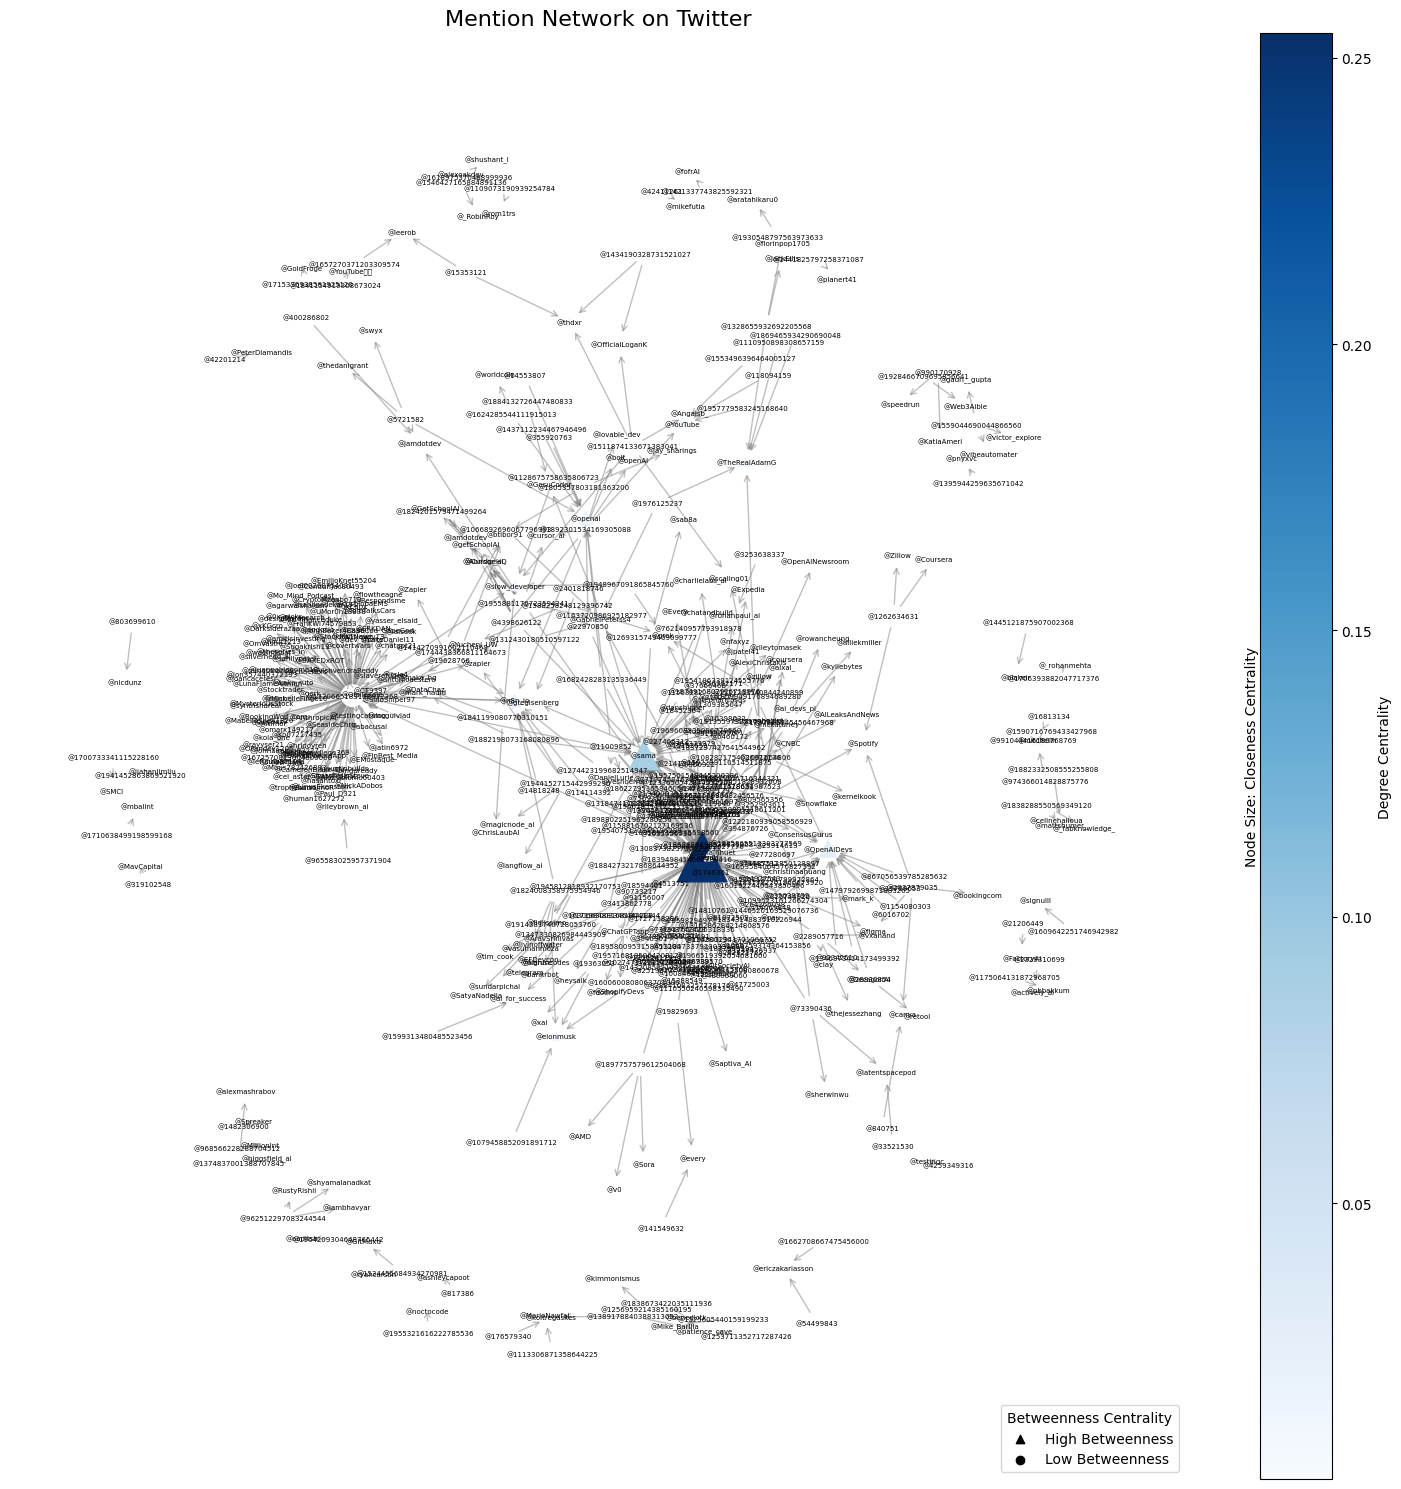

In [73]:
fig, ax = plt.subplots(figsize=(15, 15))

node_sizes = [5000 * graph_closeness[node] for node in G_mention]
node_colors = [graph_centrality[node] for node in G_mention]
node_shapes = []
betweenness_threshold = np.percentile(list(graph_betweenness.values()), 90)  # 10% teratas
for node in G_mention:
    if graph_betweenness[node] >= betweenness_threshold:
        node_shapes.append('^')
    else:
        node_shapes.append('o')

pos = nx.spring_layout(G_mention, k=0.3, seed=42)

for shape in set(node_shapes):
    node_list = [node for node in G_mention if node_shapes[list(G_mention.nodes()).index(node)] == shape]
    nx.draw_networkx_nodes(G_mention, pos,
                           nodelist=node_list,
                           node_size=[node_sizes[list(G_mention.nodes()).index(node)] for node in node_list],
                           node_color=[node_colors[list(G_mention.nodes()).index(node)] for node in node_list],
                           node_shape=shape,
                           cmap=plt.cm.Blues,
                           ax=ax)

nx.draw_networkx_edges(G_mention, pos, arrowstyle='->', arrowsize=10, edge_color='gray', alpha=0.5, ax=ax)

nx.draw_networkx_labels(G_mention, pos, font_size=5, font_color='black', ax=ax)

ax.set_title("Mention Network on Twitter", fontsize=16)

sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label="Degree Centrality")

ax.scatter([], [], c='k', marker='^', label='High Betweenness')
ax.scatter([], [], c='k', marker='o', label='Low Betweenness')
ax.legend(title="Betweenness Centrality", loc="lower right")

ax.text(1.05, 0.5, 'Node Size: Closeness Centrality', rotation=90, va='center', transform=ax.transAxes)

ax.axis('off')
plt.tight_layout()
plt.show()


Visualisasi akhir mengintegrasikan ketiga metrik centrality dalam satu grafik:

- **Ukuran node**: Proporsional dengan Closeness Centrality (node besar = posisi strategis)
- **Warna node**: Intensitas warna menunjukkan Degree Centrality (lebih gelap = lebih populer)
- **Bentuk node**: 
  - Segitiga (^) = Betweenness Centrality tinggi (top 10%)
  - Lingkaran (o) = Betweenness Centrality rendah

**Analisis Visual**:
- Node besar, gelap, berbentuk segitiga = Super influencer (tinggi di semua metrik)
- Node kecil di pinggir = Partisipan pasif
- Posisi node = Spring layout mengelompokkan komunitas yang saling terhubung

Visualisasi ini memberikan gambaran komprehensif tentang dinamika dan struktur kekuatan dalam jaringan sosial diskusi DevDay.

# Kesimpulan

### Text Clustering
Analisis clustering berhasil mengidentifikasi 3 kelompok utama tweet dengan kualitas pemisahan yang sangat baik (Silhouette Score: 0.9454). Setiap cluster merepresentasikan sub-topik berbeda dalam diskusi DevDay, yang dapat dilihat dari perbedaan kata kunci dominan di WordCloud masing-masing cluster.

### Social Network Analysis
Jaringan interaksi menunjukkan struktur yang didominasi oleh akun-akun resmi OpenAI (@OpenAI, @sama, @OpenAIDevs) sebagai pusat diskusi. Namun, jaringan memiliki resiliensi tinggi dengan distribusi penghubung yang merata (Betweenness Centrality rendah untuk semua node), menunjukkan diskusi yang organik dan tidak bergantung pada beberapa user sebagai bottleneck.